Discount 0.9615
  30 :      821       700      7972     12979     15383     16414     16839     17013     17085         0 
  31 :      854       909      8073     12923     15241     16235     16644     16811     16880         0 
  32 :      888      1122      8167     12857     15090     16046     16439     16600     16667         0 
  33 :      920      1337      8252     12781     14929     15847     16225     16380     16444         0 
  34 :      953      1554      8328     12695     14758     15638     16001     16149     16211         0 
  35 :      984      1772      8395     12598     14575     15419     15766     15908     15968         0 
  36 :     1013      1989      8451     12490     14382     15188     15520     15656     15713         0 
  37 :     1041      2205      8496     12369     14177     14946     15263     15393     15447         0 
  38 :     1067      2418      8529     12236     13959     14692     14994     15118     15169         0 
  39 :     1090      

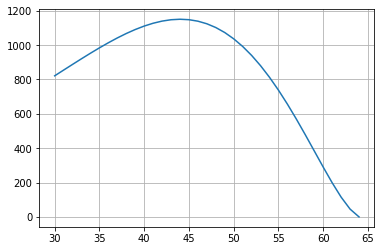

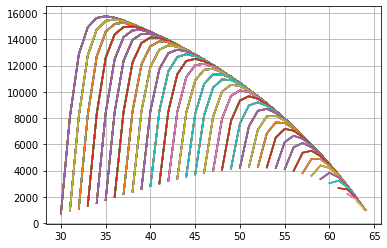

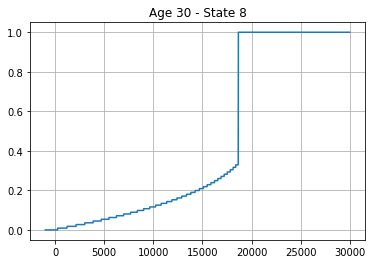

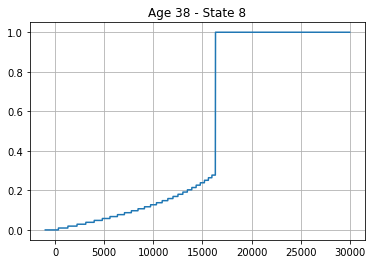

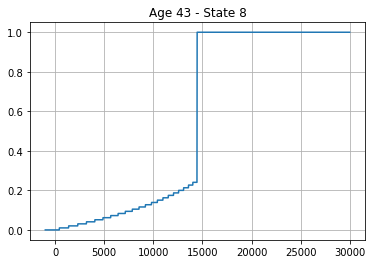

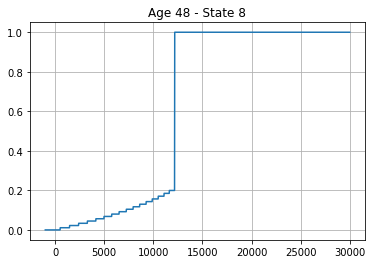

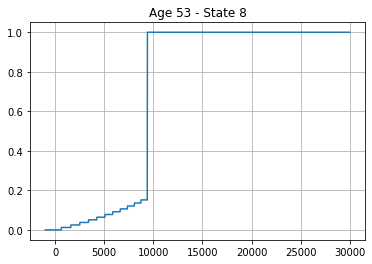

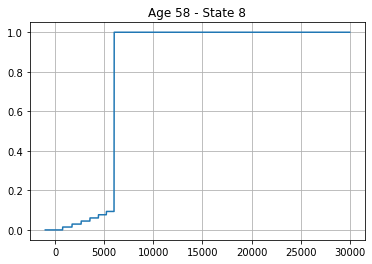

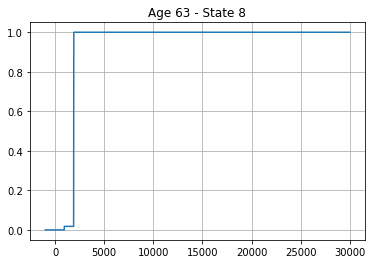

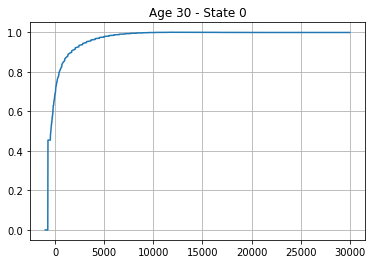

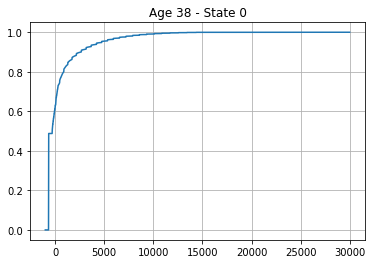

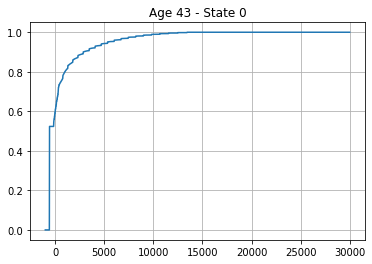

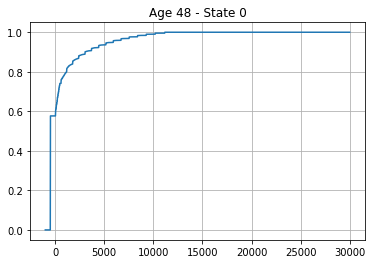

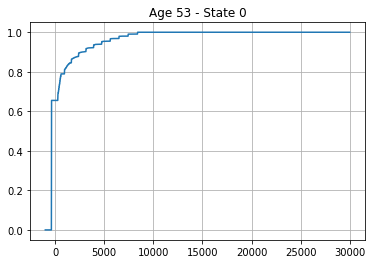

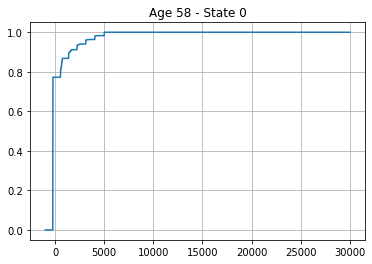

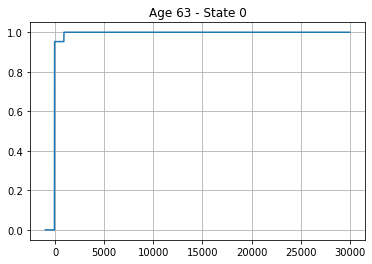

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Markov:
    def __init__(self):
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = []
        self.dPre = []
        self.dPost= []
        self.dv   = []
        self.dDK  = []
        self.dDKDistr  = []
        
        self.bCalculated = False
        self.bCalculatedDistr = False
        self.iStart = None
        self.iStop  = None
        self.fDistrLow = -1000
        self.fDistrHigh = 30000
        self.iNrBuckets = 3300
        self.fBucketWidth = (self.fDistrHigh-self.fDistrLow)/self.iNrBuckets
        self.fBucketWidthRound = self.fBucketWidth / 2.
                
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
        
    def iBucketNr(self, fValue):
        if fValue < self.fDistrLow:
            return(0)
        iBNR = (int(min(self.iNrBuckets-1,(fValue-self.fDistrLow)/self.fBucketWidth+self.fBucketWidthRound)))
        return(iBNR)
    
    def fValueOfBucket(self, iBucket):
        return(self.fBucketWidth*min(self.iNrBuckets-1,iBucket)+self.fDistrLow)
    
    def vCreateDistModel(self):
        print("You Know that you can call me only once everything is done")
        for i in range(self.iMaxTime):
            tempDK = np.zeros([self.iNrStates,self.iNrBuckets])
            self.dDKDistr.append(tempDK)
    
    def vSetDiscount(self,fIRate):
        vTemp = 1./(1.+fIRate)
        print("Discount %.4f"%(vTemp))
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        self.bCalculated = False
    
    def vSetPij(self,t,i,j,fValue):
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
    
    def vSetPre(self,t,i,j,fValue):
        self.dPre[t][i] = fValue
        self.bCalculated = False
    
    def vSetPost(self,t,i,j,fValue):
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
    
    
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])
                    
    def doCalculateDKDistr(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculatedDistr = True
        self.vCreateDistModel()
        for i in range(self.iMaxTime):
            self.dDKDistr[i] *= 0.
        # Set Boundary Conditions
        iIndexSwitch = self.iBucketNr(0)
        for j in range(self.iNrStates):
            value = 0.
            for l in range(self.iNrBuckets):
                if l > iIndexSwitch:
                           value = 1.
                self.dDKDistr[self.iStart][j,l] = value
        # Calculation                   
        for i in range(self.iStart-1, self.iStop-1,-1):
            print("Dirst DK Calc Time", i)
            for j in range(self.iNrStates):
                for k in range(self.iNrStates):
                    for l in range(self.iNrBuckets):
                        dNewXTPlusOne = (self.fValueOfBucket(l) - self.dPre[i][j])/self.dv[i] - self.dPost[i][j,k]
                        self.dDKDistr[i][j,l] += self.dPij[i][j,k]*(self.dDKDistr[i+1][k,self.iBucketNr(dNewXTPlusOne)])
                                      
    
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])
    
    def dGetDKDistr(self,iStart,iStop,iAge,iState,fValue):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculatedDistr)):
            temp = self.dGetDK(iStart,iStop,iAge,iState) # To be on the safe side
            self.doCalculateDKDistr(iStart,iStop,iAge,iState)
        return(self.dDKDistr[iAge][iState,self.iBucketNr(fValue)])
    
    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "  %7.0f "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)
    
    def PlotDKDistr(self,iStart,iStop, iSteps = None, iStates = [0], iDeltaT = 5, figNr=10, eps = 0.01,legTitle=""):
        if iSteps == None:
            iSteps = []
            for i in range(iStop,iStart,iDeltaT):
                iSteps.append(i)
            iSteps.append(iStart)
        for i in iSteps:
            for j in iStates:
                x = []
                y = []
                for k in range(self.iNrBuckets):
                    xLoc = eps + self.fValueOfBucket(k)
                    yLoc = self.dGetDKDistr(iStart,iStop,i,j,xLoc)
                    x.append(xLoc)
                    y.append(yLoc)
    
                plt.figure(figNr)
                plt.plot(x,y)
                plt.grid(True)
                mylegend = legTitle + "Age %d - State %d"%(i,j)
                plt.title(mylegend)
                figNr+=1
        
def mua(x):
    return(np.exp(-7.85785 + 0.01538*x + 0.000577355*x**2))

def mui(x):
    return(mua(x)+0.008)

def sigma(x):
    return(3.e-4 * (8.4764-1.0985*x + 0.055*x**2))

def alpha(x,k):
    return(0.773763-0.01045*(x-k + 1))

def rx(x,k,n=8):
    if (k>= n): return(0.)
    return(np.exp(-0.94*(k-1)) * alpha(x, k))

x0 = 30
s  = 65
iRate = 0.04
Annuity = 1000

iStart = s
iStop = x0

symM = Markov()
symM.vDefineModel(8+2)
symM.vSetDiscount(iRate)

for i in range(iStop,iStart):
    symM.vSetPij(i,0,0, 1. - sigma(i) - mua(i))
    symM.vSetPij(i,0,1, sigma(i))
    symM.vSetPij(i,0,9, mua(i))
    for j in range(8):
        if j<7: 
            symM.vSetPij(i,1+j,1+j+1, 1.- mui(i)- rx(i,j))
            symM.vSetPij(i,1+j,0, rx(i,j))
        else:
            symM.vSetPij(i,8,8, 1.- mui(i))
            
        symM.vSetPij(i,1+j,9, mui(i))
        symM.vSetPij(i,9,9, 1.)
        symM.vSetPre(i,1+j,1+j,Annuity)
        

x = []
y = []

for i in range(iStop,iStart):
    x.append(i)
    y.append(symM.dGetDK(iStart,iStop,i,0))
    
plt.figure(1)
plt.plot(x,y)
plt.grid(True)

plt.figure(2)
for i in range(iStop,iStart):
    x = []
    y = []
    for j in range(i,iStart):
        x.append(j)
        state = min(8,1+(j-i))
        y.append(symM.dGetDK(iStart,iStop,j,state))
        plt.plot(x,y)
plt.grid(True)
        

symM.PrintDKs(iStart,iStop)

iStop = 30

symM.PlotDKDistr(iStart,iStop,iSteps = [30,38,43,48,53,58,63], iStates = [8])
symM.PlotDKDistr(iStart,iStop,iSteps = [30,38,43,48,53,58,63], iStates = [0],figNr=20)
#symM.PlotDKDistr(iStart,iStop,iSteps = [30,38,43,48,53,58,63], iStates = [1],figNr=30)

    